## The Bootstrap
"Bootstrapping" refers to computational techniques for making inferences about a statistic beyond point estimates by treating the samples as though they were the populations of interest. Regarding the origin of the term, [An Introduction to the Bootstrap](https://cindy.informatik.uni-bremen.de/cosy/teaching/CM_2011/Eval3/pe_efron_93.pdf) states:

> The use of the term bootstrap derives from the phrase *to
pull oneself up by one's bootstrap*, widely thought to be based on
one of the eighteenth century Adventures of Baron Munchausen,
by Rudolph Erich Raspe. (The Baron had fallen to the bottom of
a deep lake. Just when it looked like all was lost, he thought to
pick himself up by his own bootstraps.)

Let us return to the experiment that we considered at the beginning of the discussion of permutation tests. Again, a new medical treatment is intended to prolong life after a form of surgery. Sixteen mice are randomly assigned to either a treatment group or control group. All mice receive the surgery, but only the treatment group will receive the new treatment. The survival time of each mouse after surgery is recorded below.


In [57]:
# survival times measured in days
import numpy as np
x = np.array([94, 197, 16, 38, 99, 141, 23])  # treatment group
y = np.array([52, 104, 146, 10, 51, 30, 40, 27, 46])  # control group

The permutation test allowed us to study whether or not the treatment had any effect on the survival times. In many studies, we are interested not only in whether there is an effect;  we are also interested in the _magnitude_ of the effect. It would be misleading to report only the difference in mean survival times, especially since the permutation test and t-test showed that there was a ~$14\%$ chance of observing such an extreme difference in means due to chance alone. In addition to reporting our statistic (the difference in means), we should also report some measurement of our uncertainty.

One way of quantifying our uncertainty is the _standard error_ of our statistic. Suppose we were to perform the same experiment (with new mice) repeatedly. Because the mice are random samples from some greater population and there will be some random error in the effect of the treatment, we would not observe the same value of the statistic every time; rather, the values of the statistic would form a distribution. The standard error is the standard deviation of this distribution.

How do we calculate the standard error if we do not know the underlying distribution from which the mice survival times are sampled? The typical approach, which we will not discuss in detail, assumes that the underlying distributions are normal; from this assumption and some math, statisticians have derived a formula to estimate the standard error of the statistic. This approach is limited in applicability, however, as it may not produce a good estimate if the original distributions are non-normal; moreover, standard error formulas are only available for a few statistics. Instead, we take a different approach, beginning with the mild assumption that the observed samples are representative of the distributions from which they were taken. We estimate the standard error by repeatedly *resampling from the observed data* (*with replacement*), calculating the statistic of the resample each time, and computing the standard deviation of the resulting distribution. This makes sense: to estimate the standard error, we would happily resample from the distribution itself it if were available to us. It's not, so we do the next best thing, which is resampling from the data we already have.

Observed Statistic Value: 30.63492063492064
Standard Error: 27.53992249756593


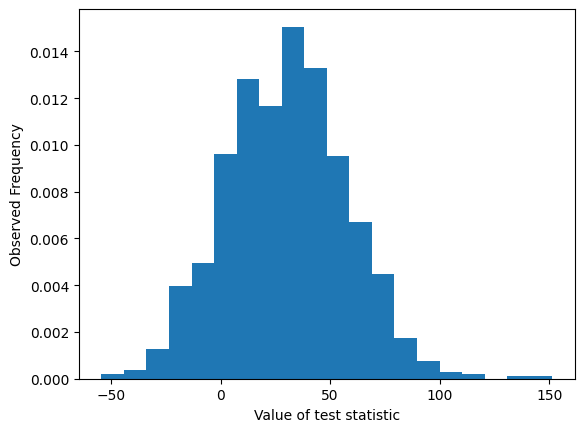

In [58]:
import matplotlib.pyplot as plt

rng = np.random.default_rng()

def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def bootstrap_distribution(x, y):
    nx, ny = len(x), len(y)
    N = 1000
    bootstrap_distribution = []
    for i in range(N):
        # random indices to resample from x and y
        ix = rng.integers(0, nx, size=nx)
        iy = rng.integers(0, ny, size=ny)
        xi = x[ix]
        yi = y[iy]
        stat = statistic(xi, yi)
        bootstrap_distribution.append(stat)
    return bootstrap_distribution

boot_dist = bootstrap_distribution(x, y)

plt.hist(boot_dist, density=True, bins=20)
plt.xlabel("Value of test statistic")
plt.ylabel("Observed Frequency")

observed_statistic = statistic(x, y)
standard_error = np.std(boot_dist, ddof=1)
print(f"Observed Statistic Value: {observed_statistic}")
print(f"Standard Error: {standard_error}")

This is precisely what `bootstrap` does.

In [59]:
from scipy import stats
# `n_resamples=1000` indicates that the statistic will be calculated for
# each of 1000 resamples.
# The meaning of `method='percentile'` will be discussed below
res = stats.bootstrap((x, y), statistic, n_resamples=1000, method='percentile')
assert res.standard_error == np.std(res.bootstrap_distribution, ddof=1)
res.standard_error

np.float64(26.96461403358856)

The two standard errors estimates differ slightly because the bootstrap algorithm is inherently stochastic, but that is OK. The best we can hope for is an approximation, and these two approximations agree with one another quite well.

An even better way of quantifying the uncertainty, especially when the distribution of the statisic is non-normal, is to produce a *confidence interval* on the statistic. Suppose we perform the experiment repeatedly and produce a "95% confidence interval" $(l_i, u_i)$ from the data in each experiment $i$; this means that we should expect the true value of the statistic (the difference in the *population* means) to be between $l_i$ and $u_i$ in 95% of the replications $i$.

In [60]:
res.confidence_interval  # 95% confidence interval by default

ConfidenceInterval(low=np.float64(-22.12023809523809), high=np.float64(85.50873015873016))

By choosing `method='percentile'` above, we indicated that bootstrap should estimate this confidence interval as the central 95% of the bootstrap distribution - that is, the boundaries of our interval will be the 2.5 and 97.5 percentiles of the bootstrap distribution.

In [61]:
ci_percentile = stats.scoreatpercentile(res.bootstrap_distribution, [2.5, 97.5])
np.testing.assert_allclose(res.confidence_interval, ci_percentile)  # confidence interval is the central 95% of the bootstrap distribution 

Again, this means that if we were to perform the mice experiment repeatedly and each time use `bootstrap` to compute such a confidence interval from the data, we would expect the confidence interval to contain the true value of the difference in mean survival times 95% of the time. Note also that our confidence interval contains 0. This is closely related to our conclusion from the hypothesis tests above: our data is not inconsistent with the null hypothesis that the treatment has no effect.

### Single-Sample, Scalar-Valued Statistics (and Confidence Intervals)
This definition of a confidence interval can be difficult to interpret correctly, so we illustrate with a simpler example. Suppose there is an election with only two candidates, `0` and `1`, and all voters will vote for either one or the other (never both, and never for neither). We wish to estimate the percentage of voters who will vote for candidate `1` by performing an experiment before the election: we will ask a random sample of 1000 voters who the will vote for on election day. The results are stored in the array `sample`.

In [62]:
# Rather than entering `sample` directly, let's generate one to work with.
# To simulate the results of such an experiment, suppose that the true 
# (but unknown) percentage of voters who will vote for candidate `1` is 75%. 
# If we sample voters at random from the population before the election and 
# ask them who they will vote for, the responses will follow a Bernoulli 
# distribution with shape parameter `p=0.75`.
p = 0.75
dist = stats.bernoulli(p=p)
sample = dist.rvs(size=1000)
vote_for_0 = np.sum(sample == 0)
vote_for_1 = np.sum(sample == 1)
print(f"{vote_for_0} for candidate 0, {vote_for_1} for candidate 1")

239 for candidate 0, 761 for candidate 1


The statistic we wish to estimate is the percentage of voters who will vote for candidate 1, so we can produce a *point estimate* of the statistic from the sample as:

In [63]:
def statistic(sample, axis=0):
    return np.sum(sample, axis=axis) / sample.shape[axis]
statistic(sample)

np.float64(0.761)

`bootstrap` can produce a confidence interval around the point estimate.

In [64]:
# As with `permutation_test`, the first argument of `bootstrap` needs to be a *sequence* of samples
data = (sample,)
# Passing `confidence_level=0.9` produces a 90% confidence interval
res = stats.bootstrap(data, statistic, confidence_level=0.9)
res.confidence_interval

ConfidenceInterval(low=np.float64(0.738), high=np.float64(0.783))

Suppose we perform the same experiment $100$ times, each time collecting new data from the same population, but computing the confidence interval in the same way.

In [65]:
# lower and upper limits of confidence intervals produced by `bootstrap`
n_replications = 100  # 100 replications of the same experiment
n_observations = 1000  # 1000 observations per sample

# Draw 100 new samples from the same population of voters, each with 1000 observations
sample = dist.rvs(size=(100, 1000)) 

# bootstrap the 90% confidence interval for all 100 samples (10 at a time)
res = stats.bootstrap((sample,), statistic, confidence_level=0.9, axis=1, batch=10)
li, ui = res.confidence_interval
    
# This was equivalent to (but faster than) the following    
# li = np.empty((n_replications,))
# ui = np.empty((n_replications,))
# for i in range(n_replications):
#     sample = dist.rvs(size=n_observations)  # collect a new sample from the same population of voters
#     res = stats.bootstrap((sample,), statistic, confidence_level=0.9, vectorized=False)
#     li[i], ui[i] = res.confidence_interval

We expect that the confidence interval will contains the true value of the statistic ($p=0.75$) approximately 90% of the time.

In [66]:
contained = (li < p) & (p < ui)
print(np.sum(contained))

85


### Paired-Sample, Vector-Valued Statistics

[An Introduction to the Bootstrap](https://books.google.com/books?id=MWC1DwAAQBAJ&printsec=frontcover) considers a small data set collected when studying a medical device for continuously delivering an anti-inflammatory hormone to test subjects. The arrays `x` and `y` record the number of hours the device was worn and the amount of hormone remaining in the device, respectively.

In [67]:
x = np.array([99, 152, 293, 155, 196, 53, 184, 171, 52, 376, 385, 402, 29, 76, 296, 151, 177, 209, 119, 188, 115, 88, 58, 49, 150, 107, 125])  # hours worn
y = np.array([25.8, 20.5, 14.3, 23.2, 20.6, 31.1, 20.9, 20.9, 30.4, 16.3, 11.6, 11.8, 32.5, 32.0, 18.0, 24.1, 26.5, 25.8, 28.8, 22.0, 29.7, 28.9, 32.8, 32.5, 25.4, 31.7, 28.5])  # amount remaining (units unspecified)

A standard linear regression is performed in SciPy as follows.

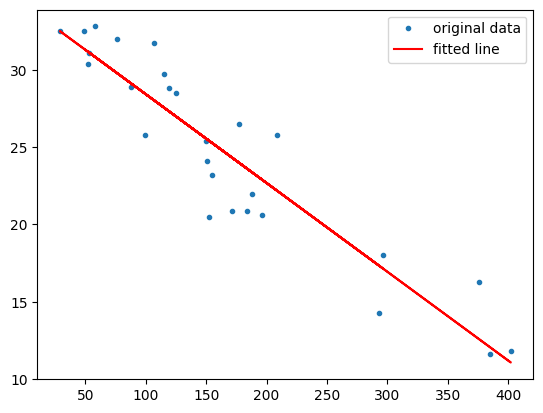

The slope estimate is: -0.0574462986976377
The intercept estimate is: 34.16752817399911
The slope standard error is: 0.004464173160311544
The intercept standard error is: 0.8671972620941928


In [68]:
res_lr = stats.linregress(x, y)

plt.plot(x, y, '.', label='original data')
plt.plot(x, res_lr.intercept + res_lr.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
print(f"The slope estimate is: {res_lr.slope}")
print(f"The intercept estimate is: {res_lr.intercept}")
print(f"The slope standard error is: {res_lr.stderr}")
print(f"The intercept standard error is: {res_lr.intercept_stderr}")

`linregress` produces point estimates of the slope and intercept as well as standard errors for each statistic, assuming that the residuals between the best fit line and the data are normally distributed. We can test the normality assumption using `stats.shapiro`.

In [69]:
e = y - res_lr.intercept + res_lr.slope*x
stats.shapiro(e)

ShapiroResult(statistic=np.float64(0.9171467338281578), pvalue=np.float64(0.03371957451361999))

Although the $p$-value is not small enough to conclusively reject the null hypothesis at all reasonable confidence levels, it does suggest that we might want to relax the residual normality assumption. `bootstrap` makes no such assumption about the residuals, and it can go beyond the standard errors, producing bias-corrected confidence intervals. The standard errors produced by `bootstrap` match those produced by `linregress` fairly well; however `linregress` may overestimate these quantities for this data.

In [70]:
def statistic(x, y):
    res = stats.linregress(x, y)
    return res.slope, res.intercept

res = stats.bootstrap((x, y), statistic, vectorized=False, paired=True)

print(f"The slope standard error is: {res.standard_error[0]}")
print(f"The intercept standard error is: {res.standard_error[1]}")
print(f"The confidence interval on the slope is: {res.confidence_interval.low[0], res.confidence_interval.high[0]}")
print(f"The confidence interval on the intercept is: {res.confidence_interval.low[1], res.confidence_interval.high[1]}")

The slope standard error is: 0.004256458827963682
The intercept standard error is: 0.7318479374367336
The confidence interval on the slope is: (np.float64(-0.065201094833876), np.float64(-0.048888808577362455))
The confidence interval on the intercept is: (np.float64(32.48219631962461), np.float64(35.43983728581776))


Again, because the statistic has multiple values, a visualization of the bootstrap distribution may be more informative.

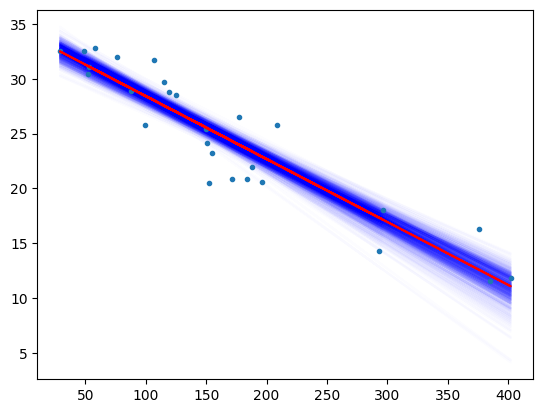

In [71]:
for m, b in res.bootstrap_distribution.T[::10]:
    plt.plot(x, m*x + b, color='b', alpha=0.01)
plt.plot(x, y, '.', label='original data')
plt.plot(x, res_lr.intercept + res_lr.slope*x, 'r', label='fitted line')

A major advantage of the bootstrap is that it can produce standard errors and confidence intervals even in more general regression models that have no simple analytical solutions, such as when the regression function is nonlinear in the parameters and when using fitting methods other than least squares.

### Gotchas

Our final example will show yet another application of the `bootstrap` chosen to illustrate common pitfalls.

[An Introduction to the Bootstrap](https://books.google.com/books?id=MWC1DwAAQBAJ&printsec=frontcover) presents a study about whether regular doses of aspirin can prevent heart attacks. Subjects were randomly assigned to two groups: 11,037 received aspirin pills, and the remaining 11,034 received placebos. The subjects were instructed to take one pill every other day, and the scientists recorded the number of subjects who experienced a heart attack during the study period: 104 in the aspirin group, and 189 in the placebo group. The statistic to assess the effectiveness of aspirin was the relative prevalence of heart attacks in the aspirin group versus the placebo group.

In [72]:
x = np.zeros(11037)  # 11037 subjects in the aspirin group
x[:104] = 1  # 104 experience a heart attack
y = np.zeros(11034)  # 11034 subjects in the placebo group
y[:189] = 1  # 189 experience a heart attack
def statistic(x, y):
    return (np.sum(x)/len(x))/(np.sum(y)/len(y))
statistic(x, y)

np.float64(0.5501149812103875)

The risk of heart atttack for aspirin-takers seemed to be approximately half that of placebo-takers.

Suppose we wish to generate a 95% confidence interval to quantify our uncertainty.

In [74]:
try:
    stats.bootstrap((x, y), statistic, confidence_level=0.95)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

This reminds us that all the data needs to be passed in as a single sequence, not two separate arguments `x` and `y`.

In [77]:
data = (x, y)  
try:
    print(stats.bootstrap(data, statistic, confidence_level=0.95))
except Exception as e:
    print(f"{type(e).__name__}: {e}")

BootstrapResult(confidence_interval=ConfidenceInterval(low=np.float64(0.4277683107867941), high=np.float64(0.69299340235736)), bootstrap_distribution=array([0.5046247 , 0.5674133 , 0.51308801, ..., 0.59358861, 0.57380849,
       0.6517565 ], shape=(9999,)), standard_error=np.float64(0.06739687684822862))


`bootstrap` offers a `method` argument that selects how the confidence interval is to be estimated from the `bootstrap` distribution; the three methods `{'BCa', 'percentile', 'basic'}` vary in their performance and accuracy. `BCa` is the most computationally intensive but tends to be the most accurate, so it is the default.  However, it is currently only available when our data has only one independent sample, whereas our data consists of two independent samples `x` and `y`. Let's try another option, `percentile`.

In [78]:
try:
    print(stats.bootstrap(data, statistic, method='basic', confidence_level=0.95))
except Exception as e:
    print(f"{type(e).__name__}: {e}")

BootstrapResult(confidence_interval=ConfidenceInterval(low=np.float64(0.4021948969363609), high=np.float64(0.6698192076866984)), bootstrap_distribution=array([0.56005715, 0.68843558, 0.51946661, ..., 0.42441291, 0.6431    ,
       0.54758981], shape=(9999,)), standard_error=np.float64(0.06826385148825591))


Unlike `permutation_test`, `bootstrap` expects `statistic` to be vectorized by default. We can solve this by passing `vectorized=False`.

In [79]:
res = stats.bootstrap(data, statistic, method='percentile', confidence_level=0.95, vectorized=False)
res.confidence_interval

ConfidenceInterval(low=np.float64(0.43168884955476), high=np.float64(0.6925491351335755))

Alternatively, we can vectorize our statistic by making it accept a parameter `axis` and having it work along the specified axis-slice of N-dimensional arrays `x` and `y`.

In [81]:
def statistic(x, y, axis=0):
    return (np.sum(x, axis=axis)/x.shape[axis])/(np.sum(y, axis=axis)/y.shape[axis])

try:
    res = stats.bootstrap(data, statistic, method='percentile', confidence_level=0.95)
    print(res.confidence_interval)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

ConfidenceInterval(low=np.float64(0.43203724030285573), high=np.float64(0.694726367242388))


Depending on your computer's hardware, you may run into a MemoryError there. Vectorized computations require a lot of memory. The default value of `n_resamples` is $9,999$, and there are a total of $11,037 + 11,034 = 22,071$ observations. Therefore, the resampled data arrays will contain a total of $9,999 \cdot 22071 = 220,687,929$ elements. Each element is stored in double precision (8-bytes), so at least 1.7GB will be used during the calculation. To relax the memory requirement, we'll process the data in batches of 100 resamples rather than all at once.

In [82]:
res = stats.bootstrap(data, statistic, method='percentile', confidence_level=0.95, batch=100)
res.confidence_interval

ConfidenceInterval(low=np.float64(0.4291516119836382), high=np.float64(0.6926407056187763))

## Conclusion

The resampling approaches in SciPy can be used not only to replicate the results of most of SciPy's hypothesis tests, but to

- improve the accuracy of statistical tests for small sample sizes and in the presence of ties,
- provide standard errors and confidence intervals for arbitrary statistics, and
- easily implement statistical tests that SciPy does not yet offer.